In [2]:
import numpy as np
import scipy.io
import random
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras import backend as K

import sys, os
import math
from collections import defaultdict

from keras.preprocessing import sequence
from keras.layers import  Activation, Embedding
from keras.layers import LSTM, Bidirectional
from keras.layers import Conv1D, MaxPooling1D
from keras.utils.np_utils import to_categorical


Using TensorFlow backend.


In [0]:
import tensorflow as tf
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 

In [4]:
K.set_session(sess)
K.tensorflow_backend._get_available_gpus()

[]

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [0]:
file_id = {'cyto':'1UA-Bjhjg0dICu-HSp1gDSx2Vb8Qssa8w', 'mito':'1-ZYvmJ4ISyJFbnTxGgyi3haXZh4RB4mE', \
           'nucleus':'1kyK4uiBuf_FU68gsmTEzL27Zyr1YLLKN', 'secreted':'1HmkIExfTkn5M_94XNNOdNvuPV5R7fU3T'}

import io
from googleapiclient.http import MediaIoBaseDownload


In [0]:
classes = {'cyto':0, 'mito':1, 'nucleus':2, 'secreted':3}

In [0]:
def add_proteins(data,label='blind'):
    protein = []
    vocab = []
    seq = ''
    seq_id = ''
    length = 0
    for line in data:
      line = str(line, 'utf-8')
      if line[0] == '>':
        if len(seq)>0:
            protein.append((seq,seq_id,classes[label]) if label is not 'blind' else (seq,seq_id))
            seq=''
            seq_id = ''
            if len(seq) > length:
                length = (len(seq))
            for char in seq:
                if char not in vocab:
                    vocab.append(char)
            start_of_id = 0
        start_of_id = line.find('|')
        if start_of_id > 0:
            seq_id = line[start_of_id+1:line.find('|',start_of_id+1)]
        else:
            seq_id = line[1:7]
      else:
        seq += line.strip()     
    protein.append((seq,seq_id,classes[label]) if label is not 'blind' else (seq,seq_id))
    if len(seq) > length:
        length = (len(seq))
    for char in seq:
        if char not in vocab:
            vocab.append(char)
    return protein, length, vocab

def load_file():
    list_protein = []
    new_protein = []
    max_length = 0
    vocab = []
    for label in classes.keys():
        request = drive_service.files().get_media(fileId=file_id[label])
        downloaded = io.BytesIO()
        downloader = MediaIoBaseDownload(downloaded, request)
        done = False
        while done is False:
          # _ is a placeholder for a progress object that we ignore.
          # (Our file is small, so we skip reporting progress.)
          _, done = downloader.next_chunk()

        downloaded.seek(0)
        data = downloaded.readlines()
        new_protein, length, new_vocab = add_proteins(data,label)
        for char in new_vocab:
            if char not in vocab:
                vocab.append(char)
        list_protein += new_protein
        if length > max_length:
            max_length = length 
        
    return list_protein, max_length, vocab  

In [0]:
data_all, max_len, vocab = load_file()
vocab += ["_","X","U","B"]

In [0]:
import string

def vectorize(seq,maxlen):
    vector = []
    if len(seq) > maxlen:
      len_seq = len(seq)
      mid = math.floor(maxlen/2)
      new_seq = seq[:mid]
      new_seq += seq[-mid:]
      seq = new_seq
    for each in seq:
        for char in each:
            vec = (vocab.index(char)+1) if char in vocab else (len(vocab)+1)
            if vec == (len(vocab)+1):
                print(char)
            vector.append(vec)
    
    return(vector)
    

In [0]:
def build_split_dataset(data, split_factor):
    random.shuffle(data)
    size_data = len(data)
    train_split = math.floor(size_data*(1-split_factor))
    train_data = data[:train_split]
    test_data = data[train_split:]
    return train_data, test_data


In [0]:
X, Test = build_split_dataset(data_all,0.1)

In [126]:
def get_ratios(data):
    sequences,seq_id,labels = zip(*data)
    size_data = len(data)
    for label_name in classes.keys():
        print(label_name,labels.count(classes[label_name])/size_data if size_data > 0 else 0)
    
get_ratios(X)
get_ratios(Test)
max_len

cyto 0.3234124593324497
mito 0.14049885528376913
nucleus 0.3630557898541993
secreted 0.17303289552958187
cyto 0.3466955579631636
mito 0.14409534127843987
nucleus 0.3261105092091008
secreted 0.18309859154929578


1415

In [127]:
#Split Factor
split_factor = 0.1

# Embedding
max_features = 25
maxlen = 400
embedding_size = 16

# Convolution
kernel_size = 4
filters = 16
pool_size = 4

# LSTM
lstm_output_size = 32

# Training
batch_size = 128
epochs = 100



print('Loading data...')
'''
Split training and dev set
'''
dev_split = math.floor(len(X)*(1-split_factor))
X_T = X[:dev_split]
X_Dev = X[dev_split:]

x_train, train_ids, y_train = zip(*X_T)
x_dev, dev_ids, y_dev = zip(*X_Dev)
x_test, test_ids, y_test = zip(*Test)
print(len(x_train), 'train sequences')
print(len(x_dev), 'dev sequences')
print(len(x_test), 'test sequences')

def vec_all(seqs,maxlen):
    vec = []
    for seq in seqs:
        vec.append(vectorize(seq,maxlen))
    return vec
    

train_vec = vec_all(x_train,maxlen)
    
dev_vec = vec_all(x_dev,maxlen)

test_vec = vec_all(x_test,maxlen)



print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(train_vec, maxlen=maxlen)
x_dev = sequence.pad_sequences(dev_vec, maxlen=maxlen)
x_test = sequence.pad_sequences(test_vec, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_dev shape:', x_dev.shape)
print('x_test shape:', x_test.shape)

y_train = list(y_train)
y_dev = list(y_dev)
y_test = list(y_test)

Loading data...
7469 train sequences
830 dev sequences
923 test sequences
Pad sequences (samples x time)
x_train shape: (7469, 400)
x_dev shape: (830, 400)
x_test shape: (923, 400)


In [0]:
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

In [129]:
print('Build model...')
modelCL = Sequential()
modelCL.add(Embedding(max_features, embedding_size, input_length=maxlen))

modelCL.add(Dropout(0.2))
modelCL.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
modelCL.add(MaxPooling1D(pool_size=pool_size))

modelCL.add(Bidirectional(LSTM(lstm_output_size)))
modelCL.add(Dropout(0.4))
modelCL.add(Dense(4))
modelCL.add(Activation('softmax'))
modelCL.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
history = modelCL.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_dev, y_dev),verbose=True)
score, acc = modelCL.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 7469 samples, validate on 830 samples
Epoch 1/100
7469/7469 [==============================] - 15s 2ms/step - loss: 1.3070 - acc: 0.3540 - val_loss: 1.2382 - val_acc: 0.3783
Epoch 2/100
7469/7469 [==============================] - 12s 2ms/step - loss: 1.2003 - acc: 0.4250 - val_loss: 1.1132 - val_acc: 0.4627
Epoch 3/100
7469/7469 [==============================] - 12s 2ms/step - loss: 1.1115 - acc: 0.4647 - val_loss: 1.0675 - val_acc: 0.4831
Epoch 4/100
7469/7469 [==============================] - 12s 2ms/step - loss: 1.0855 - acc: 0.4781 - val_loss: 1.0807 - val_acc: 0.4747
Epoch 5/100
1408/7469 [====>.........................] - ETA: 9s - loss: 1.0846 - acc: 0.4808

7469/7469 [==============================] - 12s 2ms/step - loss: 1.0713 - acc: 0.4816 - val_loss: 1.0639 - val_acc: 0.4916
Epoch 6/100
7469/7469 [==============================] - 12s 2ms/step - loss: 1.0409 - acc: 0.4928 - val_loss: 1.0252 - val_acc: 0.4855
Epoch 7/100
7469/7469 [==============================] - 12s 2ms/step - loss: 1.0004 - acc: 0.5264 - val_loss: 0.9968 - val_acc: 0.5229
Epoch 8/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.9717 - acc: 0.5501 - val_loss: 0.9706 - val_acc: 0.5301
Epoch 9/100
5504/7469 [=====================>........] - ETA: 3s - loss: 0.9662 - acc: 0.5480

7469/7469 [==============================] - 12s 2ms/step - loss: 0.9636 - acc: 0.5472 - val_loss: 0.9605 - val_acc: 0.5386
Epoch 10/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.9198 - acc: 0.5769 - val_loss: 0.9656 - val_acc: 0.5398
Epoch 11/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.9085 - acc: 0.5800 - val_loss: 0.9325 - val_acc: 0.5651
Epoch 12/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.8848 - acc: 0.5973 - val_loss: 0.9048 - val_acc: 0.5807
Epoch 13/100
6272/7469 [========================>.....] - ETA: 1s - loss: 0.8604 - acc: 0.6046

7469/7469 [==============================] - 12s 2ms/step - loss: 0.8621 - acc: 0.6040 - val_loss: 0.8732 - val_acc: 0.6000
Epoch 14/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.8510 - acc: 0.6064 - val_loss: 0.8580 - val_acc: 0.5976
Epoch 15/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.8401 - acc: 0.6156 - val_loss: 0.8734 - val_acc: 0.6133
Epoch 16/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.8375 - acc: 0.6163 - val_loss: 0.8460 - val_acc: 0.5964
Epoch 17/100
5760/7469 [======================>.......] - ETA: 2s - loss: 0.8429 - acc: 0.6113

7469/7469 [==============================] - 12s 2ms/step - loss: 0.8395 - acc: 0.6127 - val_loss: 0.8449 - val_acc: 0.6120
Epoch 18/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.8332 - acc: 0.6165 - val_loss: 0.8574 - val_acc: 0.6096
Epoch 19/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.8180 - acc: 0.6257 - val_loss: 0.8375 - val_acc: 0.6157
Epoch 20/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.8115 - acc: 0.6336 - val_loss: 0.8305 - val_acc: 0.6205
Epoch 21/100
6400/7469 [========================>.....] - ETA: 1s - loss: 0.8122 - acc: 0.6325

7469/7469 [==============================] - 12s 2ms/step - loss: 0.8102 - acc: 0.6326 - val_loss: 0.8225 - val_acc: 0.6277
Epoch 22/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.8062 - acc: 0.6397 - val_loss: 0.8147 - val_acc: 0.6373
Epoch 23/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.8008 - acc: 0.6358 - val_loss: 0.8357 - val_acc: 0.6084
Epoch 24/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7903 - acc: 0.6349 - val_loss: 0.8197 - val_acc: 0.6181
Epoch 25/100
6400/7469 [========================>.....] - ETA: 1s - loss: 0.7822 - acc: 0.6466

7469/7469 [==============================] - 12s 2ms/step - loss: 0.7827 - acc: 0.6471 - val_loss: 0.8195 - val_acc: 0.6313
Epoch 26/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7831 - acc: 0.6445 - val_loss: 0.8162 - val_acc: 0.6145
Epoch 27/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7810 - acc: 0.6443 - val_loss: 0.7935 - val_acc: 0.6446
Epoch 28/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7764 - acc: 0.6499 - val_loss: 0.7821 - val_acc: 0.6434
Epoch 29/100
6016/7469 [=======================>......] - ETA: 2s - loss: 0.7717 - acc: 0.6531

7469/7469 [==============================] - 12s 2ms/step - loss: 0.7717 - acc: 0.6515 - val_loss: 0.7926 - val_acc: 0.6434
Epoch 30/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7671 - acc: 0.6491 - val_loss: 0.7828 - val_acc: 0.6518
Epoch 31/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7605 - acc: 0.6520 - val_loss: 0.7881 - val_acc: 0.6434
Epoch 32/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7570 - acc: 0.6610 - val_loss: 0.7859 - val_acc: 0.6446
Epoch 33/100
5504/7469 [=====================>........] - ETA: 3s - loss: 0.7500 - acc: 0.6601

7469/7469 [==============================] - 12s 2ms/step - loss: 0.7553 - acc: 0.6564 - val_loss: 0.7695 - val_acc: 0.6590
Epoch 34/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7459 - acc: 0.6601 - val_loss: 0.7651 - val_acc: 0.6506
Epoch 35/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7625 - acc: 0.6481 - val_loss: 0.7759 - val_acc: 0.6410
Epoch 36/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7474 - acc: 0.6619 - val_loss: 0.7631 - val_acc: 0.6651
Epoch 37/100
4864/7469 [==================>...........] - ETA: 4s - loss: 0.7402 - acc: 0.6622

7469/7469 [==============================] - 12s 2ms/step - loss: 0.7455 - acc: 0.6581 - val_loss: 0.7719 - val_acc: 0.6410
Epoch 38/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7389 - acc: 0.6690 - val_loss: 0.7653 - val_acc: 0.6602
Epoch 39/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7320 - acc: 0.6688 - val_loss: 0.7546 - val_acc: 0.6602
Epoch 40/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7297 - acc: 0.6658 - val_loss: 0.7479 - val_acc: 0.6566
Epoch 41/100
5248/7469 [====================>.........] - ETA: 3s - loss: 0.7120 - acc: 0.6801

7469/7469 [==============================] - 12s 2ms/step - loss: 0.7270 - acc: 0.6760 - val_loss: 0.7639 - val_acc: 0.6578
Epoch 42/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7295 - acc: 0.6713 - val_loss: 0.7581 - val_acc: 0.6470
Epoch 43/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7201 - acc: 0.6771 - val_loss: 0.7474 - val_acc: 0.6723
Epoch 44/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7207 - acc: 0.6745 - val_loss: 0.7548 - val_acc: 0.6711
Epoch 45/100
5632/7469 [=====================>........] - ETA: 2s - loss: 0.7206 - acc: 0.6770

7469/7469 [==============================] - 12s 2ms/step - loss: 0.7188 - acc: 0.6773 - val_loss: 0.7401 - val_acc: 0.6675
Epoch 46/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7119 - acc: 0.6747 - val_loss: 0.7369 - val_acc: 0.6687
Epoch 47/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7123 - acc: 0.6736 - val_loss: 0.7296 - val_acc: 0.6711
Epoch 48/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7066 - acc: 0.6764 - val_loss: 0.7355 - val_acc: 0.6759
Epoch 49/100
5632/7469 [=====================>........] - ETA: 2s - loss: 0.7086 - acc: 0.6784

7469/7469 [==============================] - 12s 2ms/step - loss: 0.7084 - acc: 0.6771 - val_loss: 0.7537 - val_acc: 0.6663
Epoch 50/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7045 - acc: 0.6804 - val_loss: 0.7323 - val_acc: 0.6759
Epoch 51/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7044 - acc: 0.6832 - val_loss: 0.7177 - val_acc: 0.6747
Epoch 52/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.7018 - acc: 0.6870 - val_loss: 0.7210 - val_acc: 0.6771
Epoch 53/100
5248/7469 [====================>.........] - ETA: 3s - loss: 0.7091 - acc: 0.6833

7469/7469 [==============================] - 12s 2ms/step - loss: 0.7051 - acc: 0.6816 - val_loss: 0.7520 - val_acc: 0.6518
Epoch 54/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6984 - acc: 0.6823 - val_loss: 0.7347 - val_acc: 0.6675
Epoch 55/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6964 - acc: 0.6831 - val_loss: 0.7414 - val_acc: 0.6711
Epoch 56/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6993 - acc: 0.6848 - val_loss: 0.7249 - val_acc: 0.6699
Epoch 57/100
6528/7469 [=========================>....] - ETA: 1s - loss: 0.6878 - acc: 0.6889

7469/7469 [==============================] - 12s 2ms/step - loss: 0.6893 - acc: 0.6895 - val_loss: 0.7190 - val_acc: 0.6807
Epoch 58/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6931 - acc: 0.6867 - val_loss: 0.7223 - val_acc: 0.6759
Epoch 59/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6949 - acc: 0.6876 - val_loss: 0.7100 - val_acc: 0.6747
Epoch 60/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6878 - acc: 0.6903 - val_loss: 0.7150 - val_acc: 0.6723
Epoch 61/100
6144/7469 [=======================>......] - ETA: 2s - loss: 0.6779 - acc: 0.6911

7469/7469 [==============================] - 12s 2ms/step - loss: 0.6744 - acc: 0.6941 - val_loss: 0.7087 - val_acc: 0.6723
Epoch 62/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6776 - acc: 0.6844 - val_loss: 0.7163 - val_acc: 0.6627
Epoch 63/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6751 - acc: 0.6945 - val_loss: 0.7121 - val_acc: 0.6783
Epoch 64/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6777 - acc: 0.6943 - val_loss: 0.7148 - val_acc: 0.6735
Epoch 65/100
6272/7469 [========================>.....] - ETA: 1s - loss: 0.6794 - acc: 0.6942

7469/7469 [==============================] - 12s 2ms/step - loss: 0.6764 - acc: 0.6929 - val_loss: 0.7163 - val_acc: 0.6602
Epoch 66/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6680 - acc: 0.6971 - val_loss: 0.7156 - val_acc: 0.6807
Epoch 67/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6673 - acc: 0.6993 - val_loss: 0.7138 - val_acc: 0.6855
Epoch 68/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6682 - acc: 0.7012 - val_loss: 0.7245 - val_acc: 0.6614
Epoch 69/100
4992/7469 [===================>..........] - ETA: 3s - loss: 0.6708 - acc: 0.6923

7469/7469 [==============================] - 12s 2ms/step - loss: 0.6701 - acc: 0.6902 - val_loss: 0.7296 - val_acc: 0.6398
Epoch 70/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6687 - acc: 0.6970 - val_loss: 0.7040 - val_acc: 0.6783
Epoch 71/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6545 - acc: 0.7065 - val_loss: 0.7196 - val_acc: 0.6880
Epoch 72/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6632 - acc: 0.7004 - val_loss: 0.7295 - val_acc: 0.6759
Epoch 73/100
5504/7469 [=====================>........] - ETA: 3s - loss: 0.6721 - acc: 0.6959

7469/7469 [==============================] - 12s 2ms/step - loss: 0.6701 - acc: 0.6946 - val_loss: 0.7263 - val_acc: 0.6735
Epoch 74/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6645 - acc: 0.7014 - val_loss: 0.7246 - val_acc: 0.6855
Epoch 75/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6473 - acc: 0.7072 - val_loss: 0.7076 - val_acc: 0.6807
Epoch 76/100
7469/7469 [==============================] - 13s 2ms/step - loss: 0.6590 - acc: 0.7084 - val_loss: 0.7121 - val_acc: 0.6855
Epoch 77/100
6656/7469 [=========================>....] - ETA: 1s - loss: 0.6483 - acc: 0.7094

7469/7469 [==============================] - 12s 2ms/step - loss: 0.6489 - acc: 0.7080 - val_loss: 0.6912 - val_acc: 0.6976
Epoch 78/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6640 - acc: 0.6996 - val_loss: 0.7090 - val_acc: 0.6928
Epoch 79/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6472 - acc: 0.7112 - val_loss: 0.7251 - val_acc: 0.6735
Epoch 80/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6466 - acc: 0.7053 - val_loss: 0.7069 - val_acc: 0.6831
Epoch 81/100
6272/7469 [========================>.....] - ETA: 1s - loss: 0.6454 - acc: 0.7095

7469/7469 [==============================] - 12s 2ms/step - loss: 0.6473 - acc: 0.7099 - val_loss: 0.6913 - val_acc: 0.6952
Epoch 82/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6530 - acc: 0.7061 - val_loss: 0.7084 - val_acc: 0.6795
Epoch 83/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6428 - acc: 0.7103 - val_loss: 0.7247 - val_acc: 0.6795
Epoch 84/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6416 - acc: 0.7124 - val_loss: 0.6964 - val_acc: 0.6711
Epoch 85/100
5632/7469 [=====================>........] - ETA: 2s - loss: 0.6398 - acc: 0.7175

7469/7469 [==============================] - 12s 2ms/step - loss: 0.6433 - acc: 0.7142 - val_loss: 0.6833 - val_acc: 0.6892
Epoch 86/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6370 - acc: 0.7087 - val_loss: 0.6846 - val_acc: 0.6783
Epoch 87/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6523 - acc: 0.7120 - val_loss: 0.7097 - val_acc: 0.6855
Epoch 88/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6423 - acc: 0.7188 - val_loss: 0.7128 - val_acc: 0.6819
Epoch 89/100
5376/7469 [====================>.........] - ETA: 3s - loss: 0.6455 - acc: 0.6998

7469/7469 [==============================] - 12s 2ms/step - loss: 0.6522 - acc: 0.6982 - val_loss: 0.6932 - val_acc: 0.6819
Epoch 90/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6381 - acc: 0.7179 - val_loss: 0.6969 - val_acc: 0.6723
Epoch 91/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6305 - acc: 0.7155 - val_loss: 0.6912 - val_acc: 0.6759
Epoch 92/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6282 - acc: 0.7182 - val_loss: 0.6962 - val_acc: 0.6819
Epoch 93/100
5376/7469 [====================>.........] - ETA: 3s - loss: 0.6338 - acc: 0.7215

7469/7469 [==============================] - 12s 2ms/step - loss: 0.6349 - acc: 0.7214 - val_loss: 0.6904 - val_acc: 0.6880
Epoch 94/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6280 - acc: 0.7174 - val_loss: 0.7074 - val_acc: 0.6783
Epoch 95/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6391 - acc: 0.7160 - val_loss: 0.6939 - val_acc: 0.6795
Epoch 96/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6325 - acc: 0.7225 - val_loss: 0.6891 - val_acc: 0.6928
Epoch 97/100
5504/7469 [=====================>........] - ETA: 3s - loss: 0.6285 - acc: 0.7166

7469/7469 [==============================] - 12s 2ms/step - loss: 0.6340 - acc: 0.7212 - val_loss: 0.6926 - val_acc: 0.6819
Epoch 98/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6234 - acc: 0.7238 - val_loss: 0.6821 - val_acc: 0.6928
Epoch 99/100
7469/7469 [==============================] - 12s 2ms/step - loss: 0.6243 - acc: 0.7237 - val_loss: 0.6934 - val_acc: 0.6952
Epoch 100/100
923/923 [==============================] - 0s 367us/step
Test score: 0.6654130892014839
Test accuracy: 0.7215601293004864


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


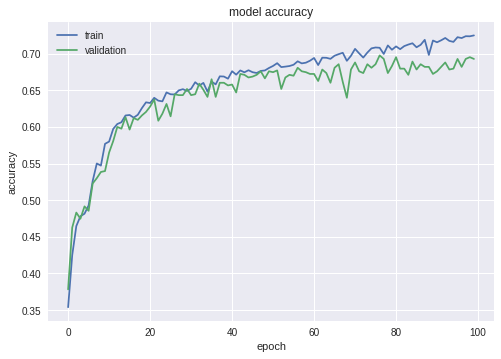

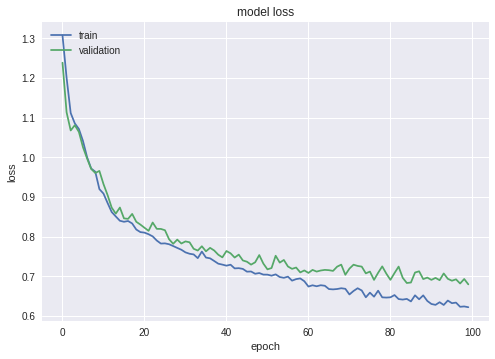

In [130]:
import matplotlib.pyplot as plt
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [46]:
y_train

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]])

In [131]:
from keras.layers import Flatten

print('Build model conv')
modelCN = Sequential()
modelCN.add(Embedding(max_features, embedding_size, input_length=maxlen))

modelCN.add(Dropout(0.2))
modelCN.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
modelCN.add(MaxPooling1D(pool_size=pool_size))

#model.add(Bidirectional(LSTM(lstm_output_size)))
#model.add(Dropout(0.4))
modelCN.add(Flatten())
modelCN.add(Dense(64))
modelCN.add(Activation('relu'))
modelCN.add(Dropout(0.5))  
modelCN.add(Dense(4))
modelCN.add(Activation('softmax'))
modelCN.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
modelCN.summary()

print('Train...')
history_cnn = modelCN.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_dev, y_dev),verbose=True)
score, acc = modelCN.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model conv
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 400, 16)           400       
_________________________________________________________________
dropout_30 (Dropout)         (None, 400, 16)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 397, 16)           1040      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 99, 16)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1584)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                101440    
_________________________________________________________________
activation_23 (Activation)   (None, 64)                0   

7469/7469 [==============================] - 3s 375us/step - loss: 1.1581 - acc: 0.4236 - val_loss: 1.0892 - val_acc: 0.4494
Epoch 3/100
7469/7469 [==============================] - 3s 373us/step - loss: 1.1018 - acc: 0.4642 - val_loss: 1.0572 - val_acc: 0.4855
Epoch 4/100
7469/7469 [==============================] - 3s 375us/step - loss: 1.0590 - acc: 0.4848 - val_loss: 1.0162 - val_acc: 0.4892
Epoch 5/100
7469/7469 [==============================] - 3s 371us/step - loss: 1.0278 - acc: 0.5041 - val_loss: 1.0057 - val_acc: 0.5169
Epoch 6/100
7469/7469 [==============================] - 3s 372us/step - loss: 1.0015 - acc: 0.5219 - val_loss: 0.9910 - val_acc: 0.4952
Epoch 7/100
7469/7469 [==============================] - 3s 372us/step - loss: 0.9677 - acc: 0.5441 - val_loss: 0.9660 - val_acc: 0.5229
Epoch 8/100
3072/7469 [===========>..................] - ETA: 1s - loss: 0.9404 - acc: 0.5511

7469/7469 [==============================] - 3s 374us/step - loss: 0.9468 - acc: 0.5536 - val_loss: 0.9569 - val_acc: 0.5361
Epoch 9/100
7469/7469 [==============================] - 3s 373us/step - loss: 0.9282 - acc: 0.5665 - val_loss: 0.9566 - val_acc: 0.5410
Epoch 10/100
7469/7469 [==============================] - 3s 372us/step - loss: 0.9055 - acc: 0.5831 - val_loss: 0.9537 - val_acc: 0.5325
Epoch 11/100
7469/7469 [==============================] - 3s 380us/step - loss: 0.8890 - acc: 0.5926 - val_loss: 0.9517 - val_acc: 0.5373
Epoch 12/100
7469/7469 [==============================] - 3s 377us/step - loss: 0.8785 - acc: 0.5987 - val_loss: 0.9492 - val_acc: 0.5337
Epoch 13/100
7469/7469 [==============================] - 3s 382us/step - loss: 0.8599 - acc: 0.6103 - val_loss: 0.9502 - val_acc: 0.5470
Epoch 14/100
2688/7469 [=========>....................] - ETA: 1s - loss: 0.8394 - acc: 0.6157

7469/7469 [==============================] - 3s 376us/step - loss: 0.8431 - acc: 0.6187 - val_loss: 0.9603 - val_acc: 0.5313
Epoch 15/100
7469/7469 [==============================] - 3s 384us/step - loss: 0.8357 - acc: 0.6250 - val_loss: 0.9652 - val_acc: 0.5265
Epoch 16/100
7469/7469 [==============================] - 3s 375us/step - loss: 0.8340 - acc: 0.6238 - val_loss: 0.9483 - val_acc: 0.5434
Epoch 17/100
7469/7469 [==============================] - 3s 375us/step - loss: 0.8090 - acc: 0.6349 - val_loss: 0.9629 - val_acc: 0.5386
Epoch 18/100
7469/7469 [==============================] - 3s 373us/step - loss: 0.7982 - acc: 0.6468 - val_loss: 0.9606 - val_acc: 0.5422
Epoch 19/100
7469/7469 [==============================] - 3s 379us/step - loss: 0.7813 - acc: 0.6504 - val_loss: 0.9709 - val_acc: 0.5470
Epoch 20/100
3200/7469 [===========>..................] - ETA: 1s - loss: 0.7797 - acc: 0.6538

7469/7469 [==============================] - 3s 377us/step - loss: 0.7743 - acc: 0.6536 - val_loss: 0.9841 - val_acc: 0.5554
Epoch 21/100
7469/7469 [==============================] - 3s 378us/step - loss: 0.7605 - acc: 0.6599 - val_loss: 0.9835 - val_acc: 0.5506
Epoch 22/100
7469/7469 [==============================] - 3s 377us/step - loss: 0.7484 - acc: 0.6614 - val_loss: 0.9989 - val_acc: 0.5410
Epoch 23/100
7469/7469 [==============================] - 3s 372us/step - loss: 0.7333 - acc: 0.6755 - val_loss: 1.0001 - val_acc: 0.5554
Epoch 24/100
7469/7469 [==============================] - 3s 371us/step - loss: 0.7319 - acc: 0.6779 - val_loss: 0.9973 - val_acc: 0.5506
Epoch 25/100
7469/7469 [==============================] - 3s 372us/step - loss: 0.7162 - acc: 0.6913 - val_loss: 1.0187 - val_acc: 0.5458
Epoch 26/100
3584/7469 [=============>................] - ETA: 1s - loss: 0.6857 - acc: 0.7001

7469/7469 [==============================] - 3s 381us/step - loss: 0.7065 - acc: 0.6943 - val_loss: 1.0059 - val_acc: 0.5361
Epoch 27/100
7469/7469 [==============================] - 3s 375us/step - loss: 0.7018 - acc: 0.6822 - val_loss: 1.0113 - val_acc: 0.5590
Epoch 28/100
7469/7469 [==============================] - 3s 380us/step - loss: 0.6896 - acc: 0.6907 - val_loss: 1.0369 - val_acc: 0.5566
Epoch 29/100
7469/7469 [==============================] - 3s 380us/step - loss: 0.6759 - acc: 0.6951 - val_loss: 1.0467 - val_acc: 0.5422
Epoch 30/100
7469/7469 [==============================] - 3s 374us/step - loss: 0.6602 - acc: 0.7030 - val_loss: 1.0752 - val_acc: 0.5482
Epoch 31/100
7469/7469 [==============================] - 3s 373us/step - loss: 0.6480 - acc: 0.7133 - val_loss: 1.0717 - val_acc: 0.5458
Epoch 32/100
2432/7469 [========>.....................] - ETA: 1s - loss: 0.6508 - acc: 0.7027

7469/7469 [==============================] - 3s 378us/step - loss: 0.6457 - acc: 0.7178 - val_loss: 1.0578 - val_acc: 0.5446
Epoch 33/100
7469/7469 [==============================] - 3s 375us/step - loss: 0.6396 - acc: 0.7112 - val_loss: 1.0798 - val_acc: 0.5518
Epoch 34/100
7469/7469 [==============================] - 3s 377us/step - loss: 0.6178 - acc: 0.7171 - val_loss: 1.0855 - val_acc: 0.5482
Epoch 35/100
7469/7469 [==============================] - 3s 375us/step - loss: 0.6072 - acc: 0.7282 - val_loss: 1.1066 - val_acc: 0.5578
Epoch 36/100
7469/7469 [==============================] - 3s 373us/step - loss: 0.6042 - acc: 0.7287 - val_loss: 1.1272 - val_acc: 0.5566
Epoch 37/100
7469/7469 [==============================] - 3s 384us/step - loss: 0.5933 - acc: 0.7312 - val_loss: 1.1166 - val_acc: 0.5494
Epoch 38/100
2816/7469 [==========>...................] - ETA: 1s - loss: 0.5870 - acc: 0.7390

7469/7469 [==============================] - 3s 377us/step - loss: 0.5844 - acc: 0.7399 - val_loss: 1.1340 - val_acc: 0.5494
Epoch 39/100
7469/7469 [==============================] - 3s 376us/step - loss: 0.5745 - acc: 0.7474 - val_loss: 1.1349 - val_acc: 0.5506
Epoch 40/100
7469/7469 [==============================] - 3s 380us/step - loss: 0.5554 - acc: 0.7484 - val_loss: 1.1337 - val_acc: 0.5446
Epoch 41/100
7469/7469 [==============================] - 3s 378us/step - loss: 0.5663 - acc: 0.7468 - val_loss: 1.1640 - val_acc: 0.5422
Epoch 42/100
7469/7469 [==============================] - 3s 373us/step - loss: 0.5525 - acc: 0.7574 - val_loss: 1.1854 - val_acc: 0.5530
Epoch 43/100
7469/7469 [==============================] - 3s 378us/step - loss: 0.5478 - acc: 0.7583 - val_loss: 1.1946 - val_acc: 0.5494
Epoch 44/100
2944/7469 [==========>...................] - ETA: 1s - loss: 0.5623 - acc: 0.7429

7469/7469 [==============================] - 3s 381us/step - loss: 0.5505 - acc: 0.7524 - val_loss: 1.1974 - val_acc: 0.5542
Epoch 45/100
7469/7469 [==============================] - 3s 381us/step - loss: 0.5266 - acc: 0.7574 - val_loss: 1.2177 - val_acc: 0.5506
Epoch 46/100
7469/7469 [==============================] - 3s 378us/step - loss: 0.5319 - acc: 0.7545 - val_loss: 1.2092 - val_acc: 0.5422
Epoch 47/100
7469/7469 [==============================] - 3s 374us/step - loss: 0.5168 - acc: 0.7634 - val_loss: 1.2375 - val_acc: 0.5422
Epoch 48/100
7469/7469 [==============================] - 3s 375us/step - loss: 0.5091 - acc: 0.7660 - val_loss: 1.2862 - val_acc: 0.5494
Epoch 49/100
7469/7469 [==============================] - 3s 380us/step - loss: 0.5117 - acc: 0.7669 - val_loss: 1.2705 - val_acc: 0.5614
Epoch 50/100
2944/7469 [==========>...................] - ETA: 1s - loss: 0.4905 - acc: 0.7717

7469/7469 [==============================] - 3s 376us/step - loss: 0.4952 - acc: 0.7735 - val_loss: 1.2625 - val_acc: 0.5554
Epoch 51/100
7469/7469 [==============================] - 3s 374us/step - loss: 0.5014 - acc: 0.7719 - val_loss: 1.3442 - val_acc: 0.5398
Epoch 52/100
7469/7469 [==============================] - 3s 379us/step - loss: 0.4949 - acc: 0.7771 - val_loss: 1.2674 - val_acc: 0.5651
Epoch 53/100
7469/7469 [==============================] - 3s 378us/step - loss: 0.4843 - acc: 0.7733 - val_loss: 1.3047 - val_acc: 0.5422
Epoch 54/100
7469/7469 [==============================] - 3s 373us/step - loss: 0.4808 - acc: 0.7799 - val_loss: 1.3193 - val_acc: 0.5542
Epoch 55/100
7469/7469 [==============================] - 3s 377us/step - loss: 0.4618 - acc: 0.7879 - val_loss: 1.3227 - val_acc: 0.5590
Epoch 56/100
2688/7469 [=========>....................] - ETA: 1s - loss: 0.4816 - acc: 0.7827

7469/7469 [==============================] - 3s 377us/step - loss: 0.4770 - acc: 0.7823 - val_loss: 1.2718 - val_acc: 0.5506
Epoch 57/100
7469/7469 [==============================] - 3s 377us/step - loss: 0.4645 - acc: 0.7866 - val_loss: 1.3061 - val_acc: 0.5494
Epoch 58/100
7469/7469 [==============================] - 3s 380us/step - loss: 0.4579 - acc: 0.7850 - val_loss: 1.3668 - val_acc: 0.5651
Epoch 59/100
7469/7469 [==============================] - 3s 375us/step - loss: 0.4514 - acc: 0.7921 - val_loss: 1.3840 - val_acc: 0.5458
Epoch 60/100
7469/7469 [==============================] - 3s 368us/step - loss: 0.4654 - acc: 0.7862 - val_loss: 1.3047 - val_acc: 0.5590
Epoch 61/100
7469/7469 [==============================] - 3s 371us/step - loss: 0.4553 - acc: 0.7893 - val_loss: 1.4088 - val_acc: 0.5542
Epoch 62/100
3456/7469 [============>.................] - ETA: 1s - loss: 0.4301 - acc: 0.7992

7469/7469 [==============================] - 3s 373us/step - loss: 0.4313 - acc: 0.8020 - val_loss: 1.4003 - val_acc: 0.5494
Epoch 63/100
7469/7469 [==============================] - 3s 376us/step - loss: 0.4378 - acc: 0.7984 - val_loss: 1.3869 - val_acc: 0.5422
Epoch 64/100
7469/7469 [==============================] - 3s 379us/step - loss: 0.4327 - acc: 0.7957 - val_loss: 1.3714 - val_acc: 0.5518
Epoch 65/100
7469/7469 [==============================] - 3s 381us/step - loss: 0.4339 - acc: 0.7966 - val_loss: 1.4274 - val_acc: 0.5470
Epoch 66/100
7469/7469 [==============================] - 3s 378us/step - loss: 0.4235 - acc: 0.8002 - val_loss: 1.4448 - val_acc: 0.5554
Epoch 67/100
7469/7469 [==============================] - 3s 380us/step - loss: 0.4167 - acc: 0.8112 - val_loss: 1.5184 - val_acc: 0.5434
Epoch 68/100
2560/7469 [=========>....................] - ETA: 1s - loss: 0.4244 - acc: 0.8027

7469/7469 [==============================] - 3s 374us/step - loss: 0.4247 - acc: 0.8043 - val_loss: 1.4981 - val_acc: 0.5566
Epoch 69/100
7469/7469 [==============================] - 3s 380us/step - loss: 0.4197 - acc: 0.8092 - val_loss: 1.4674 - val_acc: 0.5518
Epoch 70/100
7469/7469 [==============================] - 3s 375us/step - loss: 0.4225 - acc: 0.8010 - val_loss: 1.4901 - val_acc: 0.5542
Epoch 71/100
7469/7469 [==============================] - 3s 377us/step - loss: 0.4150 - acc: 0.8063 - val_loss: 1.4578 - val_acc: 0.5566
Epoch 72/100
7469/7469 [==============================] - 3s 369us/step - loss: 0.4061 - acc: 0.8103 - val_loss: 1.4890 - val_acc: 0.5542
Epoch 73/100
7469/7469 [==============================] - 3s 379us/step - loss: 0.4049 - acc: 0.8106 - val_loss: 1.4497 - val_acc: 0.5687
Epoch 74/100
3328/7469 [============>.................] - ETA: 1s - loss: 0.3909 - acc: 0.8191

7469/7469 [==============================] - 3s 373us/step - loss: 0.4056 - acc: 0.8136 - val_loss: 1.5094 - val_acc: 0.5627
Epoch 75/100
7469/7469 [==============================] - 3s 376us/step - loss: 0.3998 - acc: 0.8175 - val_loss: 1.6199 - val_acc: 0.5470
Epoch 76/100
7469/7469 [==============================] - 3s 379us/step - loss: 0.4119 - acc: 0.8085 - val_loss: 1.5765 - val_acc: 0.5578
Epoch 77/100
7469/7469 [==============================] - 3s 379us/step - loss: 0.3967 - acc: 0.8162 - val_loss: 1.5117 - val_acc: 0.5566
Epoch 78/100
7469/7469 [==============================] - 3s 380us/step - loss: 0.3903 - acc: 0.8202 - val_loss: 1.5421 - val_acc: 0.5602
Epoch 79/100
7469/7469 [==============================] - 3s 372us/step - loss: 0.3848 - acc: 0.8168 - val_loss: 1.6111 - val_acc: 0.5506
Epoch 80/100
2432/7469 [========>.....................] - ETA: 1s - loss: 0.4156 - acc: 0.8125

7469/7469 [==============================] - 3s 380us/step - loss: 0.3899 - acc: 0.8198 - val_loss: 1.6116 - val_acc: 0.5627
Epoch 81/100
7469/7469 [==============================] - 3s 376us/step - loss: 0.3802 - acc: 0.8281 - val_loss: 1.5899 - val_acc: 0.5434
Epoch 82/100
7469/7469 [==============================] - 3s 381us/step - loss: 0.3813 - acc: 0.8230 - val_loss: 1.6285 - val_acc: 0.5482
Epoch 83/100
7469/7469 [==============================] - 3s 377us/step - loss: 0.3915 - acc: 0.8193 - val_loss: 1.5552 - val_acc: 0.5566
Epoch 84/100
7469/7469 [==============================] - 3s 376us/step - loss: 0.3789 - acc: 0.8304 - val_loss: 1.6683 - val_acc: 0.5542
Epoch 85/100
7469/7469 [==============================] - 3s 376us/step - loss: 0.3831 - acc: 0.8159 - val_loss: 1.6354 - val_acc: 0.5554
Epoch 86/100
2944/7469 [==========>...................] - ETA: 1s - loss: 0.3751 - acc: 0.8261

7469/7469 [==============================] - 3s 384us/step - loss: 0.3795 - acc: 0.8241 - val_loss: 1.5734 - val_acc: 0.5578
Epoch 87/100
7469/7469 [==============================] - 3s 384us/step - loss: 0.3822 - acc: 0.8234 - val_loss: 1.6868 - val_acc: 0.5494
Epoch 88/100
7469/7469 [==============================] - 3s 380us/step - loss: 0.3718 - acc: 0.8247 - val_loss: 1.6094 - val_acc: 0.5602
Epoch 89/100
7469/7469 [==============================] - 3s 377us/step - loss: 0.3721 - acc: 0.8254 - val_loss: 1.7541 - val_acc: 0.5506
Epoch 90/100
7469/7469 [==============================] - 3s 382us/step - loss: 0.3625 - acc: 0.8277 - val_loss: 1.7001 - val_acc: 0.5458
Epoch 91/100
7469/7469 [==============================] - 3s 381us/step - loss: 0.3765 - acc: 0.8211 - val_loss: 1.6596 - val_acc: 0.5602
Epoch 92/100
2432/7469 [========>.....................] - ETA: 1s - loss: 0.3701 - acc: 0.8220

7469/7469 [==============================] - 3s 378us/step - loss: 0.3713 - acc: 0.8241 - val_loss: 1.7513 - val_acc: 0.5711
Epoch 93/100
7469/7469 [==============================] - 3s 382us/step - loss: 0.3751 - acc: 0.8289 - val_loss: 1.6110 - val_acc: 0.5602
Epoch 94/100
7469/7469 [==============================] - 3s 377us/step - loss: 0.3715 - acc: 0.8277 - val_loss: 1.7190 - val_acc: 0.5590
Epoch 95/100
7469/7469 [==============================] - 3s 380us/step - loss: 0.3747 - acc: 0.8273 - val_loss: 1.7182 - val_acc: 0.5530
Epoch 96/100
7469/7469 [==============================] - 3s 372us/step - loss: 0.3571 - acc: 0.8329 - val_loss: 1.7863 - val_acc: 0.5651
Epoch 97/100
7469/7469 [==============================] - 3s 374us/step - loss: 0.3641 - acc: 0.8314 - val_loss: 1.7392 - val_acc: 0.5566
Epoch 98/100
2816/7469 [==========>...................] - ETA: 1s - loss: 0.3493 - acc: 0.8327

7469/7469 [==============================] - 3s 380us/step - loss: 0.3573 - acc: 0.8324 - val_loss: 1.6790 - val_acc: 0.5530
Epoch 99/100
7469/7469 [==============================] - 3s 385us/step - loss: 0.3493 - acc: 0.8408 - val_loss: 1.7652 - val_acc: 0.5530
Epoch 100/100
923/923 [==============================] - 0s 100us/step
Test score: 1.7592646458296193
Test accuracy: 0.5731310943870089


In [132]:
print('Build model fully connected')
modelD = Sequential()
modelD.add(Embedding(max_features, embedding_size, input_length=maxlen))

modelD.add(Dropout(0.2))
#model.add(Conv1D(filters,
#                 kernel_size,
#                 padding='valid',
#                 activation='relu',
#                 strides=1))
#model.add(MaxPooling1D(pool_size=pool_size))

#model.add(Bidirectional(LSTM(lstm_output_size)))
#model.add(Dropout(0.4))
modelD.add(Flatten())
modelD.add(Dense(128))
modelD.add(Activation('relu'))
modelD.add(Dropout(0.5))  
modelD.add(Dense(4))
modelD.add(Activation('softmax'))
modelD.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
modelD.summary()

print('Train...')
history_dense = modelD.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_dev, y_dev),verbose=True)
score, acc = modelD.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model fully connected
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 400, 16)           400       
_________________________________________________________________
dropout_32 (Dropout)         (None, 400, 16)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               819328    
_________________________________________________________________
activation_25 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 4)          

7469/7469 [==============================] - 2s 292us/step - loss: 0.9849 - acc: 0.5587 - val_loss: 0.9994 - val_acc: 0.4892
Epoch 3/100
7469/7469 [==============================] - 2s 295us/step - loss: 0.8002 - acc: 0.6709 - val_loss: 0.9991 - val_acc: 0.5120
Epoch 4/100
7469/7469 [==============================] - 2s 297us/step - loss: 0.6517 - acc: 0.7444 - val_loss: 1.0443 - val_acc: 0.5108
Epoch 5/100
7469/7469 [==============================] - 2s 291us/step - loss: 0.5176 - acc: 0.8135 - val_loss: 1.1095 - val_acc: 0.5265
Epoch 6/100
7469/7469 [==============================] - 2s 294us/step - loss: 0.4282 - acc: 0.8448 - val_loss: 1.1909 - val_acc: 0.5205
Epoch 7/100
7469/7469 [==============================] - 2s 292us/step - loss: 0.3444 - acc: 0.8794 - val_loss: 1.2513 - val_acc: 0.5205
Epoch 8/100
2176/7469 [=======>......................] - ETA: 1s - loss: 0.2577 - acc: 0.9191

7469/7469 [==============================] - 2s 292us/step - loss: 0.2753 - acc: 0.9059 - val_loss: 1.3090 - val_acc: 0.5265
Epoch 9/100
7469/7469 [==============================] - 2s 285us/step - loss: 0.2345 - acc: 0.9240 - val_loss: 1.3731 - val_acc: 0.5241
Epoch 10/100
7469/7469 [==============================] - 2s 292us/step - loss: 0.1922 - acc: 0.9380 - val_loss: 1.4685 - val_acc: 0.5108
Epoch 11/100
7469/7469 [==============================] - 2s 295us/step - loss: 0.1703 - acc: 0.9486 - val_loss: 1.5218 - val_acc: 0.5217
Epoch 12/100
7469/7469 [==============================] - 2s 293us/step - loss: 0.1427 - acc: 0.9537 - val_loss: 1.5918 - val_acc: 0.5096
Epoch 13/100
7469/7469 [==============================] - 2s 294us/step - loss: 0.1241 - acc: 0.9636 - val_loss: 1.6367 - val_acc: 0.5193
Epoch 14/100
5760/7469 [======================>.......] - ETA: 0s - loss: 0.1088 - acc: 0.9682

7469/7469 [==============================] - 2s 294us/step - loss: 0.1148 - acc: 0.9651 - val_loss: 1.6687 - val_acc: 0.5313
Epoch 15/100
7469/7469 [==============================] - 2s 296us/step - loss: 0.1029 - acc: 0.9688 - val_loss: 1.7080 - val_acc: 0.5349
Epoch 16/100
7469/7469 [==============================] - 2s 298us/step - loss: 0.0933 - acc: 0.9750 - val_loss: 1.7710 - val_acc: 0.5205
Epoch 17/100
7469/7469 [==============================] - 2s 302us/step - loss: 0.0835 - acc: 0.9760 - val_loss: 1.8015 - val_acc: 0.5217
Epoch 18/100
7469/7469 [==============================] - 2s 298us/step - loss: 0.0829 - acc: 0.9748 - val_loss: 1.8476 - val_acc: 0.5241
Epoch 19/100
7469/7469 [==============================] - 2s 301us/step - loss: 0.0796 - acc: 0.9748 - val_loss: 1.8747 - val_acc: 0.5253
Epoch 20/100
5760/7469 [======================>.......] - ETA: 0s - loss: 0.0674 - acc: 0.9811

7469/7469 [==============================] - 2s 292us/step - loss: 0.0672 - acc: 0.9815 - val_loss: 1.9254 - val_acc: 0.5277
Epoch 21/100
7469/7469 [==============================] - 2s 293us/step - loss: 0.0656 - acc: 0.9822 - val_loss: 1.9897 - val_acc: 0.5241
Epoch 22/100
7469/7469 [==============================] - 2s 292us/step - loss: 0.0658 - acc: 0.9803 - val_loss: 1.9941 - val_acc: 0.5253
Epoch 23/100
7469/7469 [==============================] - 2s 294us/step - loss: 0.0628 - acc: 0.9831 - val_loss: 2.0161 - val_acc: 0.5289
Epoch 24/100
7469/7469 [==============================] - 2s 288us/step - loss: 0.0609 - acc: 0.9818 - val_loss: 2.0080 - val_acc: 0.5205
Epoch 25/100
7469/7469 [==============================] - 2s 293us/step - loss: 0.0602 - acc: 0.9809 - val_loss: 2.0159 - val_acc: 0.5349
Epoch 26/100
6016/7469 [=======================>......] - ETA: 0s - loss: 0.0555 - acc: 0.9830

7469/7469 [==============================] - 2s 293us/step - loss: 0.0569 - acc: 0.9821 - val_loss: 2.0646 - val_acc: 0.5133
Epoch 27/100
7469/7469 [==============================] - 2s 294us/step - loss: 0.0503 - acc: 0.9863 - val_loss: 2.0959 - val_acc: 0.5181
Epoch 28/100
7469/7469 [==============================] - 2s 295us/step - loss: 0.0516 - acc: 0.9845 - val_loss: 2.0658 - val_acc: 0.5120
Epoch 29/100
7469/7469 [==============================] - 2s 292us/step - loss: 0.0467 - acc: 0.9857 - val_loss: 2.1220 - val_acc: 0.5133
Epoch 30/100
7469/7469 [==============================] - 2s 290us/step - loss: 0.0452 - acc: 0.9862 - val_loss: 2.1293 - val_acc: 0.5108
Epoch 31/100
7469/7469 [==============================] - 2s 282us/step - loss: 0.0431 - acc: 0.9854 - val_loss: 2.1880 - val_acc: 0.5072
Epoch 32/100
6016/7469 [=======================>......] - ETA: 0s - loss: 0.0481 - acc: 0.9855

7469/7469 [==============================] - 2s 284us/step - loss: 0.0470 - acc: 0.9863 - val_loss: 2.1905 - val_acc: 0.5000
Epoch 33/100
7469/7469 [==============================] - 2s 281us/step - loss: 0.0419 - acc: 0.9874 - val_loss: 2.1996 - val_acc: 0.5048
Epoch 34/100
7469/7469 [==============================] - 2s 283us/step - loss: 0.0401 - acc: 0.9862 - val_loss: 2.2322 - val_acc: 0.5120
Epoch 35/100
7469/7469 [==============================] - 2s 287us/step - loss: 0.0439 - acc: 0.9853 - val_loss: 2.2249 - val_acc: 0.5181
Epoch 36/100
7469/7469 [==============================] - 2s 287us/step - loss: 0.0414 - acc: 0.9850 - val_loss: 2.2340 - val_acc: 0.5108
Epoch 37/100
7469/7469 [==============================] - 2s 284us/step - loss: 0.0421 - acc: 0.9858 - val_loss: 2.2667 - val_acc: 0.5193
Epoch 38/100
5888/7469 [======================>.......] - ETA: 0s - loss: 0.0420 - acc: 0.9856

7469/7469 [==============================] - 2s 283us/step - loss: 0.0425 - acc: 0.9850 - val_loss: 2.1642 - val_acc: 0.5133
Epoch 39/100
7469/7469 [==============================] - 2s 282us/step - loss: 0.0387 - acc: 0.9871 - val_loss: 2.3125 - val_acc: 0.5145
Epoch 40/100
7469/7469 [==============================] - 2s 281us/step - loss: 0.0398 - acc: 0.9874 - val_loss: 2.2939 - val_acc: 0.5108
Epoch 41/100
7469/7469 [==============================] - 2s 279us/step - loss: 0.0355 - acc: 0.9888 - val_loss: 2.2194 - val_acc: 0.5060
Epoch 42/100
7469/7469 [==============================] - 2s 289us/step - loss: 0.0372 - acc: 0.9892 - val_loss: 2.2678 - val_acc: 0.5205
Epoch 43/100
7469/7469 [==============================] - 2s 280us/step - loss: 0.0351 - acc: 0.9890 - val_loss: 2.3044 - val_acc: 0.5084
Epoch 44/100
6016/7469 [=======================>......] - ETA: 0s - loss: 0.0378 - acc: 0.9879

7469/7469 [==============================] - 2s 283us/step - loss: 0.0377 - acc: 0.9878 - val_loss: 2.3439 - val_acc: 0.5169
Epoch 45/100
7469/7469 [==============================] - 2s 285us/step - loss: 0.0339 - acc: 0.9898 - val_loss: 2.3245 - val_acc: 0.5084
Epoch 46/100
7469/7469 [==============================] - 2s 287us/step - loss: 0.0324 - acc: 0.9897 - val_loss: 2.3492 - val_acc: 0.5000
Epoch 47/100
7469/7469 [==============================] - 2s 286us/step - loss: 0.0318 - acc: 0.9906 - val_loss: 2.3859 - val_acc: 0.4940
Epoch 48/100
7469/7469 [==============================] - 2s 284us/step - loss: 0.0374 - acc: 0.9873 - val_loss: 2.3414 - val_acc: 0.5024
Epoch 49/100
7469/7469 [==============================] - 2s 282us/step - loss: 0.0351 - acc: 0.9888 - val_loss: 2.3241 - val_acc: 0.4988
Epoch 50/100
6016/7469 [=======================>......] - ETA: 0s - loss: 0.0349 - acc: 0.9900

7469/7469 [==============================] - 2s 284us/step - loss: 0.0355 - acc: 0.9888 - val_loss: 2.2979 - val_acc: 0.5145
Epoch 51/100
7469/7469 [==============================] - 2s 281us/step - loss: 0.0349 - acc: 0.9889 - val_loss: 2.2933 - val_acc: 0.5145
Epoch 52/100
7469/7469 [==============================] - 2s 286us/step - loss: 0.0348 - acc: 0.9884 - val_loss: 2.3041 - val_acc: 0.4964
Epoch 53/100
7469/7469 [==============================] - 2s 282us/step - loss: 0.0373 - acc: 0.9885 - val_loss: 2.3428 - val_acc: 0.5048
Epoch 54/100
7469/7469 [==============================] - 2s 284us/step - loss: 0.0346 - acc: 0.9900 - val_loss: 2.3223 - val_acc: 0.5012
Epoch 55/100
7469/7469 [==============================] - 2s 285us/step - loss: 0.0298 - acc: 0.9900 - val_loss: 2.3538 - val_acc: 0.5060
Epoch 56/100
5760/7469 [======================>.......] - ETA: 0s - loss: 0.0371 - acc: 0.9875

7469/7469 [==============================] - 2s 277us/step - loss: 0.0349 - acc: 0.9882 - val_loss: 2.3689 - val_acc: 0.5157
Epoch 57/100
7469/7469 [==============================] - 2s 279us/step - loss: 0.0300 - acc: 0.9905 - val_loss: 2.4005 - val_acc: 0.5084
Epoch 58/100
7469/7469 [==============================] - 2s 280us/step - loss: 0.0292 - acc: 0.9897 - val_loss: 2.3574 - val_acc: 0.5108
Epoch 59/100
7469/7469 [==============================] - 2s 282us/step - loss: 0.0308 - acc: 0.9897 - val_loss: 2.4211 - val_acc: 0.5084
Epoch 60/100
7469/7469 [==============================] - 2s 281us/step - loss: 0.0283 - acc: 0.9901 - val_loss: 2.4447 - val_acc: 0.5084
Epoch 61/100
7469/7469 [==============================] - 2s 277us/step - loss: 0.0343 - acc: 0.9885 - val_loss: 2.4655 - val_acc: 0.5048
Epoch 62/100
6016/7469 [=======================>......] - ETA: 0s - loss: 0.0370 - acc: 0.9869

7469/7469 [==============================] - 2s 281us/step - loss: 0.0367 - acc: 0.9877 - val_loss: 2.3992 - val_acc: 0.5169
Epoch 63/100
7469/7469 [==============================] - 2s 279us/step - loss: 0.0318 - acc: 0.9904 - val_loss: 2.4643 - val_acc: 0.5289
Epoch 64/100
7469/7469 [==============================] - 2s 291us/step - loss: 0.0302 - acc: 0.9900 - val_loss: 2.4838 - val_acc: 0.5217
Epoch 65/100
7469/7469 [==============================] - 2s 282us/step - loss: 0.0306 - acc: 0.9889 - val_loss: 2.4662 - val_acc: 0.5241
Epoch 66/100
7469/7469 [==============================] - 2s 277us/step - loss: 0.0294 - acc: 0.9900 - val_loss: 2.4387 - val_acc: 0.5277
Epoch 67/100
7469/7469 [==============================] - 2s 282us/step - loss: 0.0306 - acc: 0.9886 - val_loss: 2.3833 - val_acc: 0.5265
Epoch 68/100
5760/7469 [======================>.......] - ETA: 0s - loss: 0.0301 - acc: 0.9901

7469/7469 [==============================] - 2s 283us/step - loss: 0.0297 - acc: 0.9904 - val_loss: 2.4252 - val_acc: 0.5313
Epoch 69/100
7469/7469 [==============================] - 2s 280us/step - loss: 0.0313 - acc: 0.9882 - val_loss: 2.3814 - val_acc: 0.5193
Epoch 70/100
7469/7469 [==============================] - 2s 284us/step - loss: 0.0300 - acc: 0.9913 - val_loss: 2.3579 - val_acc: 0.5229
Epoch 71/100
7469/7469 [==============================] - 2s 287us/step - loss: 0.0305 - acc: 0.9901 - val_loss: 2.4114 - val_acc: 0.5217
Epoch 72/100
7469/7469 [==============================] - 2s 287us/step - loss: 0.0286 - acc: 0.9892 - val_loss: 2.4778 - val_acc: 0.5253
Epoch 73/100
7469/7469 [==============================] - 2s 282us/step - loss: 0.0298 - acc: 0.9902 - val_loss: 2.4523 - val_acc: 0.5157
Epoch 74/100
5760/7469 [======================>.......] - ETA: 0s - loss: 0.0355 - acc: 0.9878

7469/7469 [==============================] - 2s 281us/step - loss: 0.0340 - acc: 0.9882 - val_loss: 2.3355 - val_acc: 0.5229
Epoch 75/100
7469/7469 [==============================] - 2s 284us/step - loss: 0.0326 - acc: 0.9892 - val_loss: 2.4285 - val_acc: 0.5313
Epoch 76/100
7469/7469 [==============================] - 2s 282us/step - loss: 0.0265 - acc: 0.9908 - val_loss: 2.5046 - val_acc: 0.5229
Epoch 77/100
7469/7469 [==============================] - 2s 283us/step - loss: 0.0324 - acc: 0.9885 - val_loss: 2.5003 - val_acc: 0.5217
Epoch 78/100
7469/7469 [==============================] - 2s 287us/step - loss: 0.0342 - acc: 0.9885 - val_loss: 2.4658 - val_acc: 0.5217
Epoch 79/100
7469/7469 [==============================] - 2s 284us/step - loss: 0.0263 - acc: 0.9908 - val_loss: 2.4502 - val_acc: 0.5277
Epoch 80/100
5760/7469 [======================>.......] - ETA: 0s - loss: 0.0258 - acc: 0.9913

7469/7469 [==============================] - 2s 284us/step - loss: 0.0276 - acc: 0.9902 - val_loss: 2.4694 - val_acc: 0.5157
Epoch 81/100
7469/7469 [==============================] - 2s 283us/step - loss: 0.0295 - acc: 0.9900 - val_loss: 2.5230 - val_acc: 0.5096
Epoch 82/100
7469/7469 [==============================] - 2s 285us/step - loss: 0.0303 - acc: 0.9886 - val_loss: 2.5742 - val_acc: 0.5241
Epoch 83/100
7469/7469 [==============================] - 2s 287us/step - loss: 0.0264 - acc: 0.9906 - val_loss: 2.5752 - val_acc: 0.5229
Epoch 84/100
7469/7469 [==============================] - 2s 284us/step - loss: 0.0309 - acc: 0.9906 - val_loss: 2.4755 - val_acc: 0.5217
Epoch 85/100
7469/7469 [==============================] - 2s 278us/step - loss: 0.0303 - acc: 0.9900 - val_loss: 2.5188 - val_acc: 0.5036
Epoch 86/100
6016/7469 [=======================>......] - ETA: 0s - loss: 0.0298 - acc: 0.9902

7469/7469 [==============================] - 2s 281us/step - loss: 0.0283 - acc: 0.9909 - val_loss: 2.6354 - val_acc: 0.5157
Epoch 87/100
7469/7469 [==============================] - 2s 283us/step - loss: 0.0253 - acc: 0.9922 - val_loss: 2.5640 - val_acc: 0.5012
Epoch 88/100
7469/7469 [==============================] - 2s 278us/step - loss: 0.0237 - acc: 0.9917 - val_loss: 2.5609 - val_acc: 0.5133
Epoch 89/100
7469/7469 [==============================] - 2s 275us/step - loss: 0.0253 - acc: 0.9922 - val_loss: 2.7343 - val_acc: 0.5048
Epoch 90/100
7469/7469 [==============================] - 2s 279us/step - loss: 0.0274 - acc: 0.9913 - val_loss: 2.5593 - val_acc: 0.5000
Epoch 91/100
7469/7469 [==============================] - 2s 279us/step - loss: 0.0321 - acc: 0.9889 - val_loss: 2.5732 - val_acc: 0.5096
Epoch 92/100
5760/7469 [======================>.......] - ETA: 0s - loss: 0.0259 - acc: 0.9911

7469/7469 [==============================] - 2s 288us/step - loss: 0.0254 - acc: 0.9913 - val_loss: 2.6221 - val_acc: 0.5024
Epoch 93/100
7469/7469 [==============================] - 2s 282us/step - loss: 0.0278 - acc: 0.9910 - val_loss: 2.6737 - val_acc: 0.5012
Epoch 94/100
7469/7469 [==============================] - 2s 290us/step - loss: 0.0301 - acc: 0.9901 - val_loss: 2.6085 - val_acc: 0.5048
Epoch 95/100
7469/7469 [==============================] - 2s 288us/step - loss: 0.0255 - acc: 0.9922 - val_loss: 2.6428 - val_acc: 0.4988
Epoch 96/100
7469/7469 [==============================] - 2s 286us/step - loss: 0.0300 - acc: 0.9898 - val_loss: 2.6846 - val_acc: 0.5012
Epoch 97/100
7469/7469 [==============================] - 2s 282us/step - loss: 0.0207 - acc: 0.9918 - val_loss: 2.7835 - val_acc: 0.4976
Epoch 98/100
6016/7469 [=======================>......] - ETA: 0s - loss: 0.0228 - acc: 0.9919

7469/7469 [==============================] - 2s 281us/step - loss: 0.0224 - acc: 0.9918 - val_loss: 2.7170 - val_acc: 0.5012
Epoch 99/100
7469/7469 [==============================] - 2s 290us/step - loss: 0.0274 - acc: 0.9913 - val_loss: 2.6501 - val_acc: 0.4964
Epoch 100/100
923/923 [==============================] - 0s 50us/step
Test score: 2.5639251017234694
Test accuracy: 0.5113759487705912


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


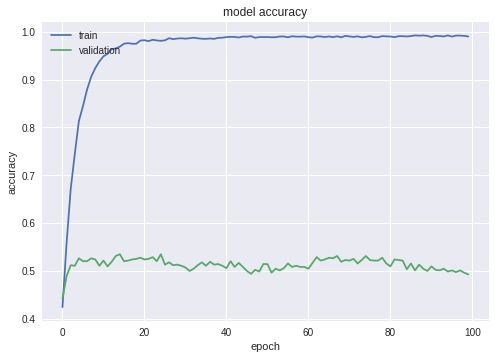

In [136]:
import matplotlib.pyplot as plt
print(history_dense.history.keys())
#  "Accuracy"
plt.plot(history_dense.history['acc'])
plt.plot(history_dense.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [134]:
print('Build model...')
modelLSTM = Sequential()
modelLSTM.add(Embedding(max_features, embedding_size, input_length=maxlen))
"""
modelLSTM.add(Dropout(0.2))
modelLSTM.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
modelLSTM.add(MaxPooling1D(pool_size=pool_size))
"""

modelLSTM.add(LSTM(lstm_output_size*2))
modelLSTM.add(Dropout(0.5))
modelLSTM.add(Dense(4))
modelLSTM.add(Activation('softmax'))
modelLSTM.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

modelLSTM.summary()

print('Train...')
historyLSTM = modelLSTM.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_dev, y_dev),verbose=True)
score, acc = modelLSTM.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 400, 16)           400       
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                20736     
_________________________________________________________________
dropout_35 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 260       
_________________________________________________________________
activation_28 (Activation)   (None, 4)                 0         
Total params: 21,396
Trainable params: 21,396
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 7469 samples, validate on 830 samples
Epoch 1/100
7469/7469 [==============================] - 35s 5ms/st

7469/7469 [==============================] - 31s 4ms/step - loss: 1.3328 - acc: 0.3839 - val_loss: 1.2910 - val_acc: 0.3639
Epoch 3/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.2800 - acc: 0.3702 - val_loss: 1.1852 - val_acc: 0.4422
Epoch 4/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1687 - acc: 0.4394 - val_loss: 1.1067 - val_acc: 0.4566
Epoch 5/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1388 - acc: 0.4450 - val_loss: 1.0890 - val_acc: 0.4699
Epoch 6/100
6656/7469 [=========================>....] - ETA: 3s - loss: 1.1247 - acc: 0.4642

7469/7469 [==============================] - 31s 4ms/step - loss: 1.1243 - acc: 0.4647 - val_loss: 1.1204 - val_acc: 0.4289
Epoch 7/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1189 - acc: 0.4615 - val_loss: 1.0821 - val_acc: 0.4747
Epoch 8/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1071 - acc: 0.4705 - val_loss: 1.0755 - val_acc: 0.4687
Epoch 9/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1094 - acc: 0.4724 - val_loss: 1.0761 - val_acc: 0.4735
Epoch 10/100
7168/7469 [===========================>..] - ETA: 1s - loss: 1.1116 - acc: 0.4770

7469/7469 [==============================] - 31s 4ms/step - loss: 1.1120 - acc: 0.4766 - val_loss: 1.0817 - val_acc: 0.4663
Epoch 11/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1065 - acc: 0.4770 - val_loss: 1.0822 - val_acc: 0.4819
Epoch 12/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.0825 - acc: 0.4873 - val_loss: 1.1089 - val_acc: 0.4614
Epoch 13/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.2170 - acc: 0.4078 - val_loss: 1.1398 - val_acc: 0.4554
Epoch 14/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.1553 - acc: 0.4449

7469/7469 [==============================] - 30s 4ms/step - loss: 1.1535 - acc: 0.4479 - val_loss: 1.1134 - val_acc: 0.4602
Epoch 15/100
7469/7469 [==============================] - 30s 4ms/step - loss: 1.1248 - acc: 0.4594 - val_loss: 1.0841 - val_acc: 0.4711
Epoch 16/100
7469/7469 [==============================] - 30s 4ms/step - loss: 1.1273 - acc: 0.4681 - val_loss: 1.0790 - val_acc: 0.4663
Epoch 17/100
7469/7469 [==============================] - 30s 4ms/step - loss: 1.1043 - acc: 0.4777 - val_loss: 1.0894 - val_acc: 0.4566
Epoch 18/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.1300 - acc: 0.4605

7469/7469 [==============================] - 31s 4ms/step - loss: 1.1302 - acc: 0.4580 - val_loss: 1.0985 - val_acc: 0.4506
Epoch 19/100
7469/7469 [==============================] - 30s 4ms/step - loss: 1.1097 - acc: 0.4749 - val_loss: 1.0715 - val_acc: 0.4639
Epoch 20/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.0872 - acc: 0.4851 - val_loss: 1.0775 - val_acc: 0.4855
Epoch 21/100
7469/7469 [==============================] - 30s 4ms/step - loss: 1.1222 - acc: 0.4756 - val_loss: 1.0881 - val_acc: 0.4904
Epoch 22/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.0966 - acc: 0.4854

7469/7469 [==============================] - 31s 4ms/step - loss: 1.0972 - acc: 0.4827 - val_loss: 1.0847 - val_acc: 0.4759
Epoch 23/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.0943 - acc: 0.4835 - val_loss: 1.0623 - val_acc: 0.4723
Epoch 24/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.0788 - acc: 0.4928 - val_loss: 1.0739 - val_acc: 0.4771
Epoch 25/100
7469/7469 [==============================] - 30s 4ms/step - loss: 1.0730 - acc: 0.4944 - val_loss: 1.0794 - val_acc: 0.4759
Epoch 26/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.0805 - acc: 0.4903

7469/7469 [==============================] - 31s 4ms/step - loss: 1.0833 - acc: 0.4896 - val_loss: 1.0792 - val_acc: 0.5157
Epoch 27/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.0986 - acc: 0.4868 - val_loss: 1.0896 - val_acc: 0.5000
Epoch 28/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1007 - acc: 0.4973 - val_loss: 1.1086 - val_acc: 0.4819
Epoch 29/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1029 - acc: 0.4880 - val_loss: 1.0519 - val_acc: 0.5193
Epoch 30/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.0890 - acc: 0.4969

7469/7469 [==============================] - 31s 4ms/step - loss: 1.0900 - acc: 0.4946 - val_loss: 1.1101 - val_acc: 0.4590
Epoch 31/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1104 - acc: 0.4707 - val_loss: 1.0806 - val_acc: 0.4639
Epoch 32/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.0860 - acc: 0.4853 - val_loss: 1.0832 - val_acc: 0.4892
Epoch 33/100
7469/7469 [==============================] - 30s 4ms/step - loss: 1.0836 - acc: 0.4965 - val_loss: 1.0823 - val_acc: 0.4675
Epoch 34/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.1247 - acc: 0.4770

7469/7469 [==============================] - 30s 4ms/step - loss: 1.1246 - acc: 0.4761 - val_loss: 1.0732 - val_acc: 0.5313
Epoch 35/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1277 - acc: 0.4805 - val_loss: 1.0985 - val_acc: 0.4482
Epoch 36/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1276 - acc: 0.4670 - val_loss: 1.0848 - val_acc: 0.4663
Epoch 37/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.2771 - acc: 0.4124 - val_loss: 1.2970 - val_acc: 0.3518
Epoch 38/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.2984 - acc: 0.3696

7469/7469 [==============================] - 31s 4ms/step - loss: 1.2962 - acc: 0.3715 - val_loss: 1.2321 - val_acc: 0.4133
Epoch 39/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.2282 - acc: 0.4263 - val_loss: 1.1614 - val_acc: 0.4241
Epoch 40/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1866 - acc: 0.4371 - val_loss: 1.1391 - val_acc: 0.4458
Epoch 41/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1601 - acc: 0.4480 - val_loss: 1.2306 - val_acc: 0.3771
Epoch 42/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.1980 - acc: 0.4206

7469/7469 [==============================] - 31s 4ms/step - loss: 1.1942 - acc: 0.4238 - val_loss: 1.1345 - val_acc: 0.4398
Epoch 43/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1565 - acc: 0.4441 - val_loss: 1.1088 - val_acc: 0.4639
Epoch 44/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1220 - acc: 0.4647 - val_loss: 1.1486 - val_acc: 0.4614
Epoch 45/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1567 - acc: 0.4515 - val_loss: 1.1697 - val_acc: 0.4289
Epoch 46/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.1706 - acc: 0.4374

7469/7469 [==============================] - 30s 4ms/step - loss: 1.1716 - acc: 0.4375 - val_loss: 1.1718 - val_acc: 0.4398
Epoch 47/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1555 - acc: 0.4651 - val_loss: 1.1222 - val_acc: 0.4687
Epoch 48/100
7469/7469 [==============================] - 30s 4ms/step - loss: 1.1290 - acc: 0.4797 - val_loss: 1.1694 - val_acc: 0.4434
Epoch 49/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1197 - acc: 0.4753 - val_loss: 1.0874 - val_acc: 0.4892
Epoch 50/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.1047 - acc: 0.4913

7469/7469 [==============================] - 31s 4ms/step - loss: 1.1017 - acc: 0.4927 - val_loss: 1.0929 - val_acc: 0.4747
Epoch 51/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.0888 - acc: 0.4900 - val_loss: 1.1150 - val_acc: 0.4795
Epoch 52/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1456 - acc: 0.4707 - val_loss: 1.2410 - val_acc: 0.4072
Epoch 53/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.2438 - acc: 0.4106 - val_loss: 1.1838 - val_acc: 0.4277
Epoch 54/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.1520 - acc: 0.4641

7469/7469 [==============================] - 31s 4ms/step - loss: 1.1511 - acc: 0.4653 - val_loss: 1.1224 - val_acc: 0.4651
Epoch 55/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1264 - acc: 0.4706 - val_loss: 1.1093 - val_acc: 0.4602
Epoch 56/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1224 - acc: 0.4758 - val_loss: 1.0800 - val_acc: 0.4904
Epoch 57/100
7469/7469 [==============================] - 30s 4ms/step - loss: 1.1333 - acc: 0.4714 - val_loss: 1.1091 - val_acc: 0.4699
Epoch 58/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.1167 - acc: 0.4761

7469/7469 [==============================] - 30s 4ms/step - loss: 1.1143 - acc: 0.4790 - val_loss: 1.0733 - val_acc: 0.4892
Epoch 59/100
7469/7469 [==============================] - 30s 4ms/step - loss: 1.1005 - acc: 0.4910 - val_loss: 1.0730 - val_acc: 0.4867
Epoch 60/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.0991 - acc: 0.4863 - val_loss: 1.0752 - val_acc: 0.4699
Epoch 61/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1407 - acc: 0.4596 - val_loss: 1.1259 - val_acc: 0.4373
Epoch 62/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.1401 - acc: 0.4548

7469/7469 [==============================] - 31s 4ms/step - loss: 1.1352 - acc: 0.4571 - val_loss: 1.0966 - val_acc: 0.4614
Epoch 63/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1561 - acc: 0.4438 - val_loss: 1.1792 - val_acc: 0.4253
Epoch 64/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1486 - acc: 0.4462 - val_loss: 1.0974 - val_acc: 0.4819
Epoch 65/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1453 - acc: 0.4489 - val_loss: 1.0979 - val_acc: 0.4928
Epoch 66/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.1360 - acc: 0.4688

7469/7469 [==============================] - 31s 4ms/step - loss: 1.1383 - acc: 0.4667 - val_loss: 1.1570 - val_acc: 0.4518
Epoch 67/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1789 - acc: 0.4630 - val_loss: 1.2346 - val_acc: 0.3904
Epoch 68/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1733 - acc: 0.4294 - val_loss: 1.1267 - val_acc: 0.4145
Epoch 69/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1448 - acc: 0.4409 - val_loss: 1.1625 - val_acc: 0.3928
Epoch 70/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.1594 - acc: 0.4183

7469/7469 [==============================] - 31s 4ms/step - loss: 1.1570 - acc: 0.4191 - val_loss: 1.1017 - val_acc: 0.4277
Epoch 71/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1319 - acc: 0.4385 - val_loss: 1.1751 - val_acc: 0.4398
Epoch 72/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1311 - acc: 0.4480 - val_loss: 1.0765 - val_acc: 0.4711
Epoch 73/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1129 - acc: 0.4564 - val_loss: 1.0575 - val_acc: 0.4651
Epoch 74/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.0898 - acc: 0.4699

7469/7469 [==============================] - 30s 4ms/step - loss: 1.0892 - acc: 0.4683 - val_loss: 1.0613 - val_acc: 0.4795
Epoch 75/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1003 - acc: 0.4689 - val_loss: 1.0722 - val_acc: 0.4723
Epoch 76/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1111 - acc: 0.4505 - val_loss: 1.0746 - val_acc: 0.4518
Epoch 77/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1758 - acc: 0.4365 - val_loss: 1.1412 - val_acc: 0.4518
Epoch 78/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.1839 - acc: 0.4357

7469/7469 [==============================] - 31s 4ms/step - loss: 1.1841 - acc: 0.4345 - val_loss: 1.1193 - val_acc: 0.4542
Epoch 79/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1476 - acc: 0.4539 - val_loss: 1.1339 - val_acc: 0.4301
Epoch 80/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1446 - acc: 0.4555 - val_loss: 1.0958 - val_acc: 0.4699
Epoch 81/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1243 - acc: 0.4628 - val_loss: 1.0973 - val_acc: 0.4880
Epoch 82/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.1512 - acc: 0.4464

7469/7469 [==============================] - 31s 4ms/step - loss: 1.1520 - acc: 0.4456 - val_loss: 1.1119 - val_acc: 0.4831
Epoch 83/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1268 - acc: 0.4543 - val_loss: 1.0948 - val_acc: 0.4675
Epoch 84/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1314 - acc: 0.4566 - val_loss: 1.0992 - val_acc: 0.4602
Epoch 85/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1603 - acc: 0.4508 - val_loss: 1.1048 - val_acc: 0.4434
Epoch 86/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.1270 - acc: 0.4506

7469/7469 [==============================] - 31s 4ms/step - loss: 1.1288 - acc: 0.4487 - val_loss: 1.1067 - val_acc: 0.4807
Epoch 87/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1123 - acc: 0.4697 - val_loss: 1.0809 - val_acc: 0.4687
Epoch 88/100
7469/7469 [==============================] - 30s 4ms/step - loss: 1.0841 - acc: 0.4800 - val_loss: 1.0545 - val_acc: 0.4928
Epoch 89/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.0783 - acc: 0.4840 - val_loss: 1.0517 - val_acc: 0.4904
Epoch 90/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.1140 - acc: 0.4621

7469/7469 [==============================] - 31s 4ms/step - loss: 1.1185 - acc: 0.4595 - val_loss: 1.0668 - val_acc: 0.4494
Epoch 91/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.0906 - acc: 0.4539 - val_loss: 1.0237 - val_acc: 0.4759
Epoch 92/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.0769 - acc: 0.4774 - val_loss: 1.0710 - val_acc: 0.4759
Epoch 93/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1012 - acc: 0.4634 - val_loss: 1.0657 - val_acc: 0.4759
Epoch 94/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.1244 - acc: 0.4605

7469/7469 [==============================] - 31s 4ms/step - loss: 1.1246 - acc: 0.4602 - val_loss: 1.1082 - val_acc: 0.4446
Epoch 95/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1318 - acc: 0.4549 - val_loss: 1.0895 - val_acc: 0.4590
Epoch 96/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.0977 - acc: 0.4757 - val_loss: 1.0647 - val_acc: 0.4711
Epoch 97/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1053 - acc: 0.4670 - val_loss: 1.0786 - val_acc: 0.4458
Epoch 98/100
7040/7469 [===========================>..] - ETA: 1s - loss: 1.0991 - acc: 0.4607

7469/7469 [==============================] - 31s 4ms/step - loss: 1.1011 - acc: 0.4590 - val_loss: 1.0487 - val_acc: 0.4723
Epoch 99/100
7469/7469 [==============================] - 31s 4ms/step - loss: 1.1120 - acc: 0.4545 - val_loss: 1.1703 - val_acc: 0.4241
Epoch 100/100
923/923 [==============================] - 1s 904us/step
Test score: 1.1094211780366248
Test accuracy: 0.437703142703419


In [0]:
predict_prob = modelCL.predict(x_test[:10])

In [68]:
predict_prob

array([[2.5294146e-05, 3.6044550e-04, 9.9961424e-01, 9.4915968e-09],
       [9.7854757e-01, 2.9509823e-05, 2.1422889e-02, 2.8734209e-10],
       [9.7295183e-01, 2.4242569e-02, 2.8055047e-03, 3.3706564e-09],
       [6.8467027e-01, 7.1305358e-06, 4.0516883e-04, 3.1491750e-01],
       [9.3559819e-01, 2.5156362e-02, 3.9202753e-02, 4.2680014e-05],
       [2.1774319e-01, 7.0872378e-01, 7.3376492e-02, 1.5644717e-04],
       [4.5767743e-03, 6.0323204e-09, 9.9542326e-01, 5.6834064e-15],
       [6.4771898e-02, 5.3611748e-02, 5.2464563e-01, 3.5697070e-01],
       [1.9138972e-03, 1.2049313e-05, 9.9590462e-01, 2.1694556e-03],
       [4.9854629e-05, 9.9966383e-01, 3.4177540e-07, 2.8596044e-04]],
      dtype=float32)

In [0]:
blind_file_id ='1ceWxZjJQ8fhh24C9B1FxPxYtjLs1GlmP'

blind_protein = []

request = drive_service.files().get_media(fileId=blind_file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  _, done = downloader.next_chunk()

downloaded.seek(0)
data = downloaded.readlines()
new_protein, blind_length, blind_vocab = add_proteins(data)

blind_protein += new_protein

In [138]:
bp_X,bp_ids = zip(*blind_protein)
bp_ids

('SEQ677',
 'SEQ231',
 'SEQ871',
 'SEQ388',
 'SEQ122',
 'SEQ758',
 'SEQ333',
 'SEQ937',
 'SEQ351',
 'SEQ202',
 'SEQ608',
 'SEQ402',
 'SEQ433',
 'SEQ821',
 'SEQ322',
 'SEQ982',
 'SEQ951',
 'SEQ173',
 'SEQ862',
 'SEQ224')

In [139]:
bp_vec = vec_all(bp_X,maxlen)
bp_vec = sequence.pad_sequences(bp_vec, maxlen=maxlen)
len(bp_vec)

20

In [140]:
predict_prob = modelCL.predict(bp_vec)
predict_prob

array([[3.49089622e-01, 1.79395273e-01, 1.28434733e-01, 3.43080372e-01],
       [4.98100137e-03, 1.08866428e-03, 2.40135798e-03, 9.91528988e-01],
       [2.42402162e-02, 1.04586617e-03, 5.47950249e-03, 9.69234467e-01],
       [6.86294019e-01, 1.74858980e-02, 2.86350757e-01, 9.86933429e-03],
       [6.73541665e-01, 2.16841735e-02, 2.97791243e-01, 6.98291278e-03],
       [4.19746220e-01, 3.07258172e-03, 5.76913774e-01, 2.67415802e-04],
       [6.17275059e-01, 7.36421496e-02, 2.92948157e-01, 1.61345638e-02],
       [6.81988657e-01, 1.07704811e-02, 3.04478884e-01, 2.76198564e-03],
       [6.65319383e-01, 9.72012281e-02, 2.36325294e-01, 1.15412136e-03],
       [5.15861571e-01, 1.88137352e-01, 2.27797776e-01, 6.82033673e-02],
       [4.41779315e-01, 3.98186088e-01, 1.32872984e-01, 2.71617174e-02],
       [4.07376468e-01, 3.85174528e-02, 5.49238622e-01, 4.86751599e-03],
       [1.68642466e-04, 5.85711541e-06, 1.51641780e-05, 9.99810398e-01],
       [6.94839805e-02, 2.81572109e-03, 1.98849831e

In [90]:
for seq in predict_prob:
  for class_prob in seq:
    print(class_prob)

0.1597852
0.8401489
6.4576496e-05
1.2705592e-06
0.0010638463
3.8018567e-05
0.9943768
0.0045214742
0.0015767778
0.008159351
0.98779386
0.002470052
1.0384147e-07
1.821056e-06
0.9999981
2.4273175e-09
1.2431112e-11
3.865172e-09
1.0
4.229802e-09
0.0001351462
2.7000808e-06
0.9998622
1.01709e-09
0.9238704
0.06935495
0.0012303389
0.005544393
0.99927455
0.00072544353
4.2943615e-08
1.0647979e-08
0.7850014
0.0017751465
0.019242823
0.19398066
1.8336573e-07
0.99998796
2.0466323e-11
1.1841646e-05
4.282252e-07
0.9999995
4.809133e-10
2.9102818e-12
3.2060746e-14
1.0
3.1545394e-14
2.8651313e-19
7.30377e-10
5.179568e-12
7.327735e-12
1.0
1.2008418e-09
5.0591365e-17
5.700446e-13
1.0
0.00046346293
4.655789e-07
0.99953604
6.1553396e-14
2.1858796e-05
4.7229543e-07
0.9999716
6.1068968e-06
0.06544089
0.02434874
0.91021025
7.014886e-08
0.2653666
0.024425441
0.710208
6.9140223e-12
2.693192e-10
1.0
6.9923602e-12
1.5023554e-11
0.6983332
0.00078906084
1.2041846e-06
0.30087665


array([[1.5978520e-01, 8.4014893e-01, 6.4576496e-05, 1.2705592e-06],
       [1.0638463e-03, 3.8018567e-05, 9.9437678e-01, 4.5214742e-03],
       [1.5767778e-03, 8.1593506e-03, 9.8779386e-01, 2.4700521e-03],
       [1.0384147e-07, 1.8210560e-06, 9.9999809e-01, 2.4273175e-09],
       [1.2431112e-11, 3.8651722e-09, 1.0000000e+00, 4.2298018e-09],
       [1.3514620e-04, 2.7000808e-06, 9.9986219e-01, 1.0170900e-09],
       [9.2387038e-01, 6.9354951e-02, 1.2303389e-03, 5.5443929e-03],
       [9.9927455e-01, 7.2544353e-04, 4.2943615e-08, 1.0647979e-08],
       [7.8500140e-01, 1.7751465e-03, 1.9242823e-02, 1.9398066e-01],
       [1.8336573e-07, 9.9998796e-01, 2.0466323e-11, 1.1841646e-05],
       [4.2822521e-07, 9.9999952e-01, 4.8091331e-10, 2.9102818e-12],
       [3.2060746e-14, 1.0000000e+00, 3.1545394e-14, 2.8651313e-19],
       [7.3037698e-10, 5.1795681e-12, 7.3277348e-12, 1.0000000e+00],
       [1.2008418e-09, 5.0591365e-17, 5.7004461e-13, 1.0000000e+00],
       [4.6346293e-04, 4.6557889e-

In [91]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 400, 16)           400       
_________________________________________________________________
dropout_7 (Dropout)          (None, 400, 16)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               819328    
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 516       
__________